<a href="https://colab.research.google.com/github/Taylor-Tian/hello-world/blob/master/validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 验证

 **学习目标：**
  * 使用多个特征而非单个特征来进一步提高模型的有效性
  * 调试模型输入数据中的问题
  * 使用测试数据集检查模型是否过拟合验证数据

 与在之前的练习中一样，我们将使用加利福尼亚州住房数据集，尝试根据 1990 年的人口普查数据在城市街区级别预测 `median_house_value`。

 ## 设置

 我们首先加载并准备数据。这一次，我们将使用多个特征，因此我们会将逻辑模块化，以对特征进行预处理：

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

 对于**训练集**，我们从共 17000 个样本中选择前 12000 个样本。

In [10]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2656.9,541.0,1434.7,503.1,3.9,2.0
std,2.1,2.0,12.6,2213.3,425.7,1175.6,387.9,1.9,1.1
min,32.5,-124.3,1.0,2.0,1.0,6.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1468.0,299.0,794.0,283.0,2.6,1.5
50%,34.3,-118.5,29.0,2132.5,435.0,1171.0,410.5,3.6,1.9
75%,37.7,-118.0,37.0,3163.2,651.0,1722.0,608.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


In [11]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,208.1
std,116.7
min,15.0
25%,119.3
50%,181.3
75%,266.3
max,500.0


 对于**验证集**，我们从共 17000 个样本中选择后 5000 个样本。

In [12]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.5,2612.0,535.5,1417.3,496.8,3.9,2.0
std,2.1,2.0,12.6,2097.5,411.3,1078.4,376.4,1.9,1.3
min,32.5,-124.2,2.0,15.0,3.0,3.0,4.0,0.5,0.0
25%,33.9,-121.7,18.0,1446.0,293.0,776.0,278.0,2.6,1.5
50%,34.2,-118.5,29.0,2113.0,430.5,1156.5,404.5,3.5,1.9
75%,37.7,-118.0,37.0,3124.0,642.2,1718.0,597.0,4.7,2.3
max,42.0,-114.5,52.0,25957.0,4798.0,10988.0,4490.0,15.0,55.2


In [13]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,205.5
std,114.2
min,17.5
25%,120.0
50%,178.5
75%,262.1
max,500.0


 ## 任务 1：检查数据
好的，我们看一下上面的数据。可以使用的输入特征有 `9` 个。

快速浏览一下表格中的值。一切看起来正常吗？看一下您可以发现多少问题。如果您没有统计学方面的背景知识，也不必担心；您可以运用常识。

有机会亲自仔细查看数据后，请查看解决方案，了解有关如何验证数据的其他思路。

 ### 解决方案

点击下方即可查看解决方案。

 我们根据基准预期情况检查一下我们的数据：

* 对于一些值（例如 `median_house_value`），我们可以检查这些值是否位于合理的范围内（请注意，这是 1990 年的数据，不是现在的！）。

* 对于 `latitude` 和 `longitude` 等其他值，我们可以通过 Google 进行快速搜索，并快速检查一下它们与预期值是否一致。

如果您仔细看，可能会发现下列异常情况：

* `median_income` 位于 3 到 15 的范围内。我们完全不清楚此范围究竟指的是什么，看起来可能是某对数尺度？无法找到相关记录；我们所能假设的只是，值越高，相应的收入越高。

* `median_house_value` 的最大值是 500001。这看起来像是某种人为设定的上限。

* `rooms_per_person` 特征通常在正常范围内，其中第 75 百分位数的值约为 2。但也有一些非常大的值（例如 18 或 55），这可能表明数据有一定程度的损坏。

我们将暂时使用提供的这些特征。但希望这些示例可帮助您较为直观地了解如何检查来自未知来源的数据。

 ## 任务 2：绘制纬度/经度与房屋价值中位数的曲线图

 我们来详细了解一下 **`latitude`** 和 **`longitude`** 这两个特征。它们是相关城市街区的地理坐标。

利用这两个特征可以提供出色的可视化结果 - 我们来绘制 `latitude` 和 `longitude` 的曲线图，然后用颜色标注 `median_house_value`。

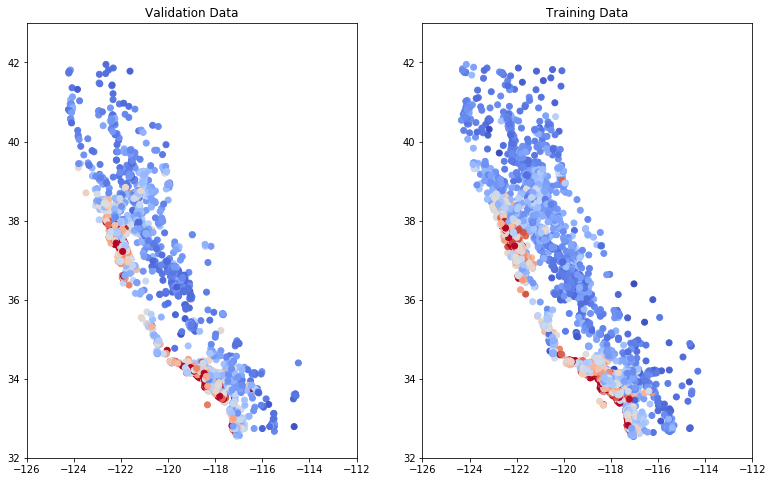

In [14]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

 稍等片刻…现在应该已经呈现出一幅不错的加利福尼亚州地图了，其中旧金山和洛杉矶等住房成本高昂的地区用红色表示。

根据训练集呈现的地图有几分像[真正的地图](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55)，但根据验证集呈现的明显不像。

**返回上面的部分，再次查看任务 1 中的数据。**

您看出训练数据和验证数据之间的特征或目标分布有任何其他差异了吗？

 ### 解决方案

点击下方即可查看解决方案。

 查看上面的摘要统计信息表格时，很容易产生想知道如何进行有用的数据检查的想法。每个街区 total_rooms 的第 <sup>75</sup> 百分位的正确值是什么？

需要注意的关键一点是，对于任何指定特征或列，训练集和验证集之间的值的分布应该大致相同。

我们真正需要担心的是，真实情况并非这样，这一事实表明我们创建训练集和验证集的拆分方式很可能存在问题。

 ## 任务 3：返回来看数据导入和预处理代码，看一下您是否发现了任何错误
如果您发现了错误，请修复该错误。将查看时间控制在一到两分钟之内。如果您未发现任何错误，请查看解决方案。

 发现并解决问题后，重新运行上面的 `latitude`/`longitude` 绘图单元格，并确认我们的健全性检查的结果看上去更好了。

顺便提一下，在这一步中，我们会学到一项重要经验。

**机器学习中的调试通常是*数据调试*而不是代码调试。**

如果数据有误，即使最高级的机器学习代码也挽救不了局面。

 ### 解决方案

点击下方即可查看解决方案。

 我们来看一下在读入数据时，我们是如何对数据进行随机化处理的。

如果我们在创建训练集和验证集之前，没有对数据进行正确的随机化处理，那么以某种特定顺序接收数据可能会导致出现问题（似乎就是此时的问题）。

 ## 任务 4：训练和评估模型

**花费约 5 分钟的时间尝试不同的超参数设置。尽可能获取最佳验证效果。**

然后，我们会使用数据集中的所有特征训练一个线性回归器，看看其表现如何。

我们来定义一下以前将数据加载到 TensorFlow 模型中时所使用的同一输入函数。


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 由于我们现在使用的是多个输入特征，因此需要把用于将特征列配置为独立函数的代码模块化。（目前此代码相当简单，因为我们的所有特征都是数值，但当我们在今后的练习中使用其他类型的特征时，会基于此代码进行构建。）

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

 接下来，继续完成下面的 `train_model()` 代码，以设置输入函数和计算预测。

**注意**：可以参考以前的练习中的代码，但要确保针对相应数据集调用 `predict()`。

比较训练数据和验证数据的损失。使用一个原始特征时，我们得到的最佳均方根误差 (RMSE) 约为 180。

现在我们可以使用多个特征，不妨看一下可以获得多好的结果。

使用我们之前了解的一些方法检查数据。这些方法可能包括：

   * 比较预测值和实际目标值的分布情况

   * 绘制预测值和目标值的散点图

   * 使用 `latitude` 和 `longitude` 绘制两个验证数据散点图：
      * 一个散点图将颜色映射到实际目标 `median_house_value`
      * 另一个散点图将颜色映射到预测的 `median_house_value`，并排进行比较。

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples,training_targets,batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets,num_epochs=1, shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples,validation_targets,batch_size=batch_size)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [19]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00001,
    steps=100,
    batch_size=1,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):


TypeError: ignored

 ### 解决方案

点击下方即可查看解决方案。

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [0]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 任务 5：基于测试数据进行评估

**在以下单元格中，载入测试数据集并据此评估模型。**

我们已对验证数据进行了大量迭代。接下来确保我们没有过拟合该特定样本集的特性。

测试数据集位于[此处](https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv)。

您的测试效果与验证效果的对比情况如何？对比情况表明您模型的泛化效果如何？

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv", sep=",")
#
# YOUR CODE HERE
#

 ### 解决方案

点击下方即可查看解决方案。

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.cn/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)